In [88]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import tensorflow as tf
from tensorflow import keras
from scipy.signal import butter, filtfilt
import time
%matplotlib inline

Global Parameters

In [89]:
num_classes = 3 #cruise, left and right
window_size = 200 #number of data points in a time window
enable_filter = False #toggle on LPF, see cutoff_freq in next field
offset = -100 #Time gap. If offset 0 then we only take points before t_m, if offset equals window_size then we only take points after t_m
no_epochs = 30
learning_rate = 0.001
batch_size = 60
start_time_column = 't_m' #Defintion of start time, can be 't_m' or 't_peak1'
participant_training_split = [6,7,8,9,10,11,12,13,14,15,16,17,18,19] #specify which participants to train on
participant_test_split = [x for x in range(20) if x not in participant_training_split] #specify which participants to test on
fs = 200 #Hz

In [90]:
#dimensions = ['mAcc_cal_0','mAcc_cal_1','mGyr_0','mGyr_2','mGyr_0_angle','mGyr_2_angle']#,'mGyr_0_angle', 'mGyr_2_angle']
# #possible dimension options: 'mAcc_cal_0','mAcc_cal_1','mAcc_cal_2','mGyr_0','mGyr_1','mGyr_2', 'xa_cal', 'ya_cal', 'za_cal', 'xg', 'yg', 'zg', 'currentSpeed', 'mGyr_0_angle','mGyr_1_angle','mGyr_2_angle',  order is important for filtering! first gyr then angle
# default phone: ['mAcc_cal_0','mAcc_cal_1','mAcc_cal_2','mGyr_0','mGyr_1','mGyr_2']
# probably best? ['mAcc_cal_0','mAcc_cal_1','mGyr_0','mGyr_2','mGyr_0_angle','mGyr_2_angle']
#dimensions = ['xa_cal','ya_cal','za_cal','xg','yg','zg'] #default Thingy
#dimensions = ['mAcc_cal_1','mAcc_cal_2','mGyr_0','mGyr_2', 'ya_cal', 'za_cal', 'xg', 'zg']
#dimensions = ['xa_cal','ya_cal','xg','zg']
#dimensions = ['xa_cal','currentSpeed','za_cal','xg','yg','zg']
#dimensions = ['mAcc_cal_0','currentSpeed','mGyr_0','mGyr_2','mGyr_0_angle','mGyr_2_angle']
#dimensions = ['mAcc_cal_0','mAcc_cal_1','mAcc_cal_2','mGyr_0','mGyr_1','mGyr_2'] #default phone
#dimensions = ['mAcc_cal_0','mAcc_cal_1','mAcc_cal_2','mGyr_0','mGyr_1','mGyr_2','mGyr_1_angle'] #default phone
dimensions = ['mAcc_cal_1','mAcc_cal_2','mGyr_0','mGyr_2', 'mGyr_2_angle']#best according to experimenting
input_dimensions = len(dimensions) #number of features

Filter parameters

In [91]:
# Define filter parameters
order = 4
cutoff_freq = 40 # Hz
# Normalize cutoff frequency
nyquist_freq = 0.5 * fs
cutoff_norm = cutoff_freq / nyquist_freq
# Define filter coefficients using Butterworth filter design
b, a = butter(order, cutoff_norm, btype='lowpass')

Data Data Data

In [92]:
def processDataFrame(df):
    df['timeStamp'] = df['timeStamp'].apply(lambda x: datetime.datetime.strptime(x, '%H:%M:%S.%f'))
    start_time = df['timeStamp'].iloc[0]
    df['Time (s)'] = (df['timeStamp'] - start_time).dt.total_seconds()
    total_time = df['Time (s)'].iloc[-1]
    fs = len(df)/total_time # Sampling frequency of Thingy, should be 200 Hz

    #P1 configuration, align coordinates of phone to thingy, dimension sync
    if "mAcc_0" in df.columns: #Phone df
        #Acc: Z = -Z, X = -Y and Y = -X
        df['mAcc_2'], df['mAcc_cal_2'], df['mAcc_0'],  df['mAcc_cal_0'], df['mAcc_1'], df['mAcc_cal_1'] = df['mAcc_2'], df['mAcc_cal_2'], -df['mAcc_1'],  -df['mAcc_cal_1'], df['mAcc_0'], -df['mAcc_cal_0']

        #Gyr: Z = -Z, Y = X, X = Y
        df['mGyr_0'], df['mGyr_1'], df['mGyr_2'] = df['mGyr_1'], df['mGyr_0'], -df['mGyr_2']

    t_interval_start = 0
    t_interval_end = total_time-0
    idx1 = (df['Time (s)'] - t_interval_start).abs().idxmin()
    idx2 = (df['Time (s)'] - t_interval_end).abs().idxmin()
    dt1 = df.loc[idx1, 'timeStamp']
    dt2 = df.loc[idx2, 'timeStamp']
    df = df.loc[(df['timeStamp'] >= dt1) & (df['timeStamp'] <= dt2)]

    return fs, df

In [93]:
# Set up the parameters
data_folder = "experiment_data"
labels_file = "labels.csv"
cruise_files = "cruise_files.csv"

labels_data = pd.read_csv(labels_file)
check_condition = (labels_data['t_peak1'] <= labels_data['t_m']) & (labels_data['t_m'] <= labels_data['t_peak2'])
if check_condition.all():
    print("All time labels ordered correctly")
else:
    print("WARNING: Some time labels are not ordered correctly")

cruise_data = pd.read_csv(cruise_files)

All time labels ordered correctly


In [94]:
def find_files(folder, _filename):
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file == _filename:
                return os.path.join(root, file)
    return None

def get_window(_df,_end_time,_window_size,_offset):
    time_diff = (_df['timeStamp'] - _end_time).abs()
    closest_index = np.argmin(np.abs(time_diff))
    #closest_value = df['timeStamp'][closest_index]
    _df.drop('timeStamp', axis=1, inplace=True)
    _window = _df.loc[(closest_index - _window_size + 1 + _offset):closest_index + _offset]
    _window.reset_index(drop=True, inplace=True)
    return _window

segments = []
train_segments = []
test_segments = []

labels = []
train_labels = []
test_labels = []

speed_labels = []
train_speed_labels = []
test_speed_labels = []

turn_labels = []
train_turn_labels = []
test_turn_labels = []

code_start_time = time.time()

#Collect left and right maneveur windows
for filename, end_time, label, speed_category, turn_type in zip(labels_data["name"], labels_data[start_time_column], labels_data['maneuver'], labels_data['speed_category'], labels_data['turn_type']):
    phone_file_path = find_files(data_folder, filename + '_phone.csv')
    gps_file_path = find_files(data_folder, filename + '_gps.csv')
    thingy_file_path = find_files(data_folder, filename + '_thingy.csv')
    print(filename)
    if phone_file_path is not None:
        ## Load data from files
        participant_no = int(filename.split('_')[0])
        df_phone = pd.read_csv(phone_file_path, header=None)
        df_gps = pd.read_csv(gps_file_path, header=None)
        df_thingy = pd.read_csv(thingy_file_path, header=None)
        df_phone.columns = ['timeStamp','mAcc_0','mAcc_1','mAcc_2','mAcc_cal_0','mAcc_cal_1','mAcc_cal_2','mGyr_0','mGyr_1','mGyr_2']
        df_gps.columns = ['timeStamp','currentSpeed','distance','mLocationLat','mLocationLong']
        df_thingy.columns = ['timeStamp','xa','ya','za','xa_cal','ya_cal','za_cal','xg','yg','zg']
        fs_phone, df_phone = processDataFrame(df_phone)
        fs_gps, df_gps = processDataFrame(df_gps)
        fs_thingy, df_thingy = processDataFrame(df_thingy)

        ## Get phone IMU data
        p_acc = df_phone.dropna(subset=['mAcc_cal_0', 'mAcc_cal_1', 'mAcc_cal_2'])[['mAcc_cal_0', 'mAcc_cal_1', 'mAcc_cal_2', 'timeStamp']]
        p_gyr = df_phone.dropna(subset=['mGyr_0', 'mGyr_1', 'mGyr_2'])[['mGyr_0', 'mGyr_1', 'mGyr_2', 'timeStamp']]
        p_acc = p_acc.reset_index(drop=True)
        p_gyr = p_gyr.reset_index(drop=True)

        ## Interpolate GPS data
        df_gps.set_index('timeStamp', inplace=True)
        df_gps = df_gps.resample('5ms').mean().interpolate(method='linear') #200Hz interpolation
        df_gps.reset_index(inplace=True)

        ## Extract window data
        end_time = pd.to_datetime(end_time).replace(year = 1900, month = 1, day = 1)
        window_acc = get_window(p_acc, end_time, window_size, offset)
        window_gyr = get_window(p_gyr, end_time, window_size, offset)
        window_thingy = get_window(df_thingy, end_time, window_size, offset)
        window_gps = get_window(df_gps, end_time, window_size, offset)
        window = pd.concat([window_acc, window_gyr, window_thingy, window_gps], axis=1, sort=False)
        if len(window) != window_size: #We cannot use this run, so we skip it
            print(f'Could not find enough data for {filename}, found {len(window)} data points, but need {window_size}')
            continue
        assert(window_size == len(window))

        ## Add window_data as sample, based on specified dimensions
        window_data = []
        for d in dimensions:
            if d in ['mAcc_cal_0', 'mAcc_cal_1', 'mAcc_cal_2', 'mGyr_0', 'mGyr_1', 'mGyr_2', 'xa_cal', 'ya_cal', 'za_cal', 'xg', 'yg', 'zg', 'currentSpeed']:
                if enable_filter:
                    window_data.append(filtfilt(b, a, window[d].values))
                else:
                    window_data.append(window[d].values)
            elif d in ['mGyr_0_angle', 'mGyr_1_angle', 'mGyr_2_angle']:
                if enable_filter:
                    window_data.append(np.cumsum(filtfilt(b, a, window[d[0:6]].values)))
                else:
                    window_data.append(np.cumsum(window[d[0:6]]))
        # Add window_data to train/test segments based on participant_no
        segments.append(window_data)
        labels.append(label)
        speed_labels.append(speed_category)
        turn_labels.append(turn_type)
        if participant_no in participant_training_split:
            train_segments.append(window_data)
            train_labels.append(label)
            train_speed_labels.append(speed_category)
            train_turn_labels.append(turn_type)
        elif participant_no in participant_test_split:
            test_segments.append(window_data)
            test_labels.append(label)
            test_speed_labels.append(speed_category)
            test_turn_labels.append(turn_type)
        else:
            print(f'Could not find participant {participant_no} in training or test split')
    else:
        print(f'Could not find file: {filename}')

#Collect cruise windows
for filename, label, speed_category in zip(cruise_data['name'], cruise_data['maneuver'], cruise_data['speed_category']):
    phone_file_path = find_files(data_folder, filename + '_phone.csv')
    gps_file_path = find_files(data_folder, filename + '_gps.csv')
    thingy_file_path = find_files(data_folder, filename + '_thingy.csv')
    print(filename)
    if phone_file_path is not None:
        ## Load data from files
        participant_no = int(filename.split('_')[0])
        df_phone = pd.read_csv(phone_file_path, header=None)
        df_gps = pd.read_csv(gps_file_path, header=None)
        df_thingy = pd.read_csv(thingy_file_path, header=None)
        df_phone.columns = ['timeStamp','mAcc_0','mAcc_1','mAcc_2','mAcc_cal_0','mAcc_cal_1','mAcc_cal_2','mGyr_0','mGyr_1','mGyr_2']
        df_gps.columns = ['timeStamp','currentSpeed','distance','mLocationLat','mLocationLong']
        df_thingy.columns = ['timeStamp','xa','ya','za','xa_cal','ya_cal','za_cal','xg','yg','zg']
        fs_phone, df_phone = processDataFrame(df_phone)
        fs_gps, df_gps = processDataFrame(df_gps)
        fs_thingy, df_thingy = processDataFrame(df_thingy)

        ## Get phone IMU data
        p_acc = df_phone.dropna(subset=['mAcc_cal_0', 'mAcc_cal_1', 'mAcc_cal_2'])[['mAcc_cal_0', 'mAcc_cal_1', 'mAcc_cal_2', 'timeStamp']]
        p_gyr = df_phone.dropna(subset=['mGyr_0', 'mGyr_1', 'mGyr_2'])[['mGyr_0', 'mGyr_1', 'mGyr_2', 'timeStamp']]
        p_acc = p_acc.reset_index(drop=True)
        p_gyr = p_gyr.reset_index(drop=True)
        #p_acc.drop('timeStamp', axis=1, inplace=True) #TODO: Why did i use this in the first place? window somthing...
        #p_gyr.drop('timeStamp', axis=1, inplace=True)

        ## Interpolate GPS data
        df_gps.set_index('timeStamp', inplace=True)
        df_gps = df_gps.resample('5ms').mean().interpolate(method='linear') #200Hz interpolation
        df_gps.reset_index(inplace=True)

        ## Extract window data
        cruise_window_middle = len(p_acc)//2 + 400 #window end is always 400 data points after middle
        end_time = p_acc.loc[cruise_window_middle, 'timeStamp']
        window_acc = get_window(p_acc, end_time, window_size, 0)
        window_gyr = get_window(p_gyr, end_time, window_size, 0)
        window_thingy = get_window(df_thingy, end_time, window_size, 0)
        window_gps = get_window(df_gps, end_time, window_size, 0)
        #window_acc = p_acc.loc[(cruise_window_middle - window_size):(cruise_window_middle - 1)]
        #window_gyr = p_gyr.loc[(cruise_window_middle - window_size):(cruise_window_middle - 1)]
        #window_thingy = df_thingy.loc[(cruise_window_middle - window_size + thingy_shift):(cruise_window_middle - 1 + thingy_shift)]
        window_acc.reset_index(drop=True, inplace=True)
        window_gyr.reset_index(drop=True, inplace=True)
        window_thingy.reset_index(drop=True, inplace=True)
        window = pd.concat([window_acc, window_gyr, window_thingy, window_gps], axis=1, sort=False)
        if len(window) != window_size: #We cannot use this run, so we skip it
            print(f'Could not find enough data for {filename}, found {len(window)} data points, but need {window_size}')
            continue
        assert(window_size == len(window))

        ## Add window_data as sample, based on specified dimensions
        window_data = []
        for d in dimensions:
            if d in ['mAcc_cal_0', 'mAcc_cal_1', 'mAcc_cal_2', 'mGyr_0', 'mGyr_1', 'mGyr_2', 'xa_cal', 'ya_cal', 'za_cal', 'xg', 'yg', 'zg', 'currentSpeed']:
                if enable_filter:
                    window_data.append(filtfilt(b, a, window[d].values))
                else:
                    window_data.append(window[d].values)
            elif d in ['mGyr_0_angle', 'mGyr_1_angle', 'mGyr_2_angle']:
                if enable_filter:
                    window_data.append(np.cumsum(filtfilt(b, a, window[d[0:6]].values)))
                else:
                    window_data.append(np.cumsum(window[d[0:6]]))
        # Add window_data to train/test segments based on participant_no
        segments.append(window_data)
        labels.append(label)
        speed_labels.append(speed_category)
        turn_labels.append(-99) # turn type not available for cruise
        if participant_no in participant_training_split:
            train_segments.append(window_data)
            train_labels.append(label)
            train_speed_labels.append(speed_category)
            train_turn_labels.append(-99)
        elif participant_no in participant_test_split:
            test_segments.append(window_data)
            test_labels.append(label)
            test_speed_labels.append(speed_category)
            test_turn_labels.append(-99)
        else:
            print(f'Could not find participant {participant_no} in training or test split')
    else:
        print(f'Could not find file: {filename}')

print(labels, len(labels))
code_time = time.time() - code_start_time
print(f'Data loading time: {code_time:.2f} seconds')

00_l_10_0_15-05-2023 15-42-59.318
00_l_10_0_15-05-2023 15-43-33.273
00_l_10_0_15-05-2023 15-44-12.979
00_l_10_0_15-05-2023 15-44-47.726
00_l_15_0_15-05-2023 15-51-23.524
00_l_15_0_15-05-2023 15-52-00.106
00_l_15_0_15-05-2023 15-52-36.524
00_l_15_0_15-05-2023 15-53-11.842
00_l_20_0_15-05-2023 15-59-24.321
00_l_20_0_15-05-2023 16-00-00.765
00_l_20_0_15-05-2023 16-00-30.185
00_l_20_0_15-05-2023 16-01-00.697
00_r_10_0_15-05-2023 15-45-41.330
00_r_10_0_15-05-2023 15-46-28.196
00_r_10_0_15-05-2023 15-47-04.847
00_r_10_0_15-05-2023 15-47-45.553
00_r_15_0_15-05-2023 15-54-09.556
00_r_15_0_15-05-2023 15-54-43.109
00_r_15_0_15-05-2023 15-55-12.961
00_r_15_0_15-05-2023 15-55-53.665
00_r_20_0_15-05-2023 16-01-57.428
00_r_20_0_15-05-2023 16-02-26.624
00_r_20_0_15-05-2023 16-02-53.972
00_r_20_0_15-05-2023 16-03-22.566
02_l_10_0_16-05-2023 10-58-43.438
02_l_10_0_16-05-2023 10-59-14.456
02_l_10_1_16-05-2023 11-13-31.670
02_l_10_1_16-05-2023 11-13-56.969
02_l_15_0_16-05-2023 11-03-52.855
02_l_15_0_16-0

Shaping data to right input format and verifying shapes

In [95]:
input_data = np.transpose(np.asarray(segments), (0, 2, 1))
train_data = np.transpose(np.asarray(train_segments), (0, 2, 1))
test_data = np.transpose(np.asarray(test_segments), (0, 2, 1))
labels = np.asarray(labels)
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)
print(f'--All data--\nData shape: {input_data.shape}, labels shape: {labels.shape}')
for label, count in Counter(labels).items():
    print(f"{label}: {count}")
print(f'\n--Training data--\nData shape: {train_data.shape}, labels shape: {train_labels.shape}')
for label, count in Counter(train_labels).items():
    print(f"{label}: {count}")
print(f'\n--Test data--\nData shape: {test_data.shape}, labels shape: {test_labels.shape}')
for label, count in Counter(test_labels).items():
    print(f"{label}: {count}")
assert(len(train_data) + len(test_data) == len(input_data))

--All data--
Data shape: (737, 200, 5), labels shape: (737,)
l: 247
r: 242
c: 248

--Training data--
Data shape: (508, 200, 5), labels shape: (508,)
l: 171
r: 169
c: 168

--Test data--
Data shape: (229, 200, 5), labels shape: (229,)
l: 76
r: 73
c: 80


LSTM Model Architecture

In [96]:
# Feature extraction network
model = keras.Sequential()
model.add(layers.Conv1D(16, kernel_size=7, padding='same', activation='relu', input_shape=(window_size, input_dimensions)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(2, kernel_size=7, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
# LSTM network
model.add(layers.LSTM(64, return_sequences=True, activation='tanh'))
# Attention mechanism
attention = layers.Dense(1, activation='tanh')(model.output)
attention = layers.Flatten()(attention)
attention = layers.Activation('softmax')(attention)
attention = layers.RepeatVector(64)(attention)
attention = layers.Permute([2, 1])(attention)
# Apply attention weights to LSTM outputs
attention_output = layers.multiply([model.output, attention])
attention_output = layers.Lambda(lambda x: keras.backend.sum(x, axis=1))(attention_output)
# Dropout layer
attention_output = layers.Dropout(0.5)(attention_output)
# Softmax classifier
output = layers.Dense(num_classes, activation='softmax')(attention_output)

# Final model
model = keras.Model(inputs=model.inputs, outputs=output)
# Compile the model
#TODO: maybe set initial learning rate
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv1d_8_input (InputLayer)    [(None, 200, 5)]     0           []                               
                                                                                                  
 conv1d_8 (Conv1D)              (None, 200, 16)      576         ['conv1d_8_input[0][0]']         
                                                                                                  
 max_pooling1d_8 (MaxPooling1D)  (None, 100, 16)     0           ['conv1d_8[0][0]']               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 100, 2)       226         ['max_pooling1d_8[0][0]']        
                                                                                            

In [113]:
# Normalize the input data
scaler = StandardScaler()
normalized_input_data = scaler.fit_transform(input_data.reshape(-1, input_dimensions)).reshape(input_data.shape)
normalized_train_data = scaler.fit_transform(train_data.reshape(-1, input_dimensions)).reshape(train_data.shape)
normalized_test_data = scaler.fit_transform(test_data.reshape(-1, input_dimensions)).reshape(test_data.shape)

# Convert string labels to integer values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_test_labels = label_encoder.fit_transform(test_labels)

labels_one_hot = keras.utils.to_categorical(encoded_labels, num_classes)
train_labels_one_hot = keras.utils.to_categorical(encoded_train_labels, num_classes)
test_labels_one_hot = keras.utils.to_categorical(encoded_test_labels, num_classes)

seed = 42 # For reproducibility
# Randomize normalized train data and labels in same order, with seed
np.random.seed(seed)
randomize = np.arange(len(normalized_train_data))
np.random.shuffle(randomize)
_X_train = normalized_train_data[randomize]
_y_train = train_labels_one_hot[randomize]
train_turn_types = np.asarray(train_turn_labels)[randomize]
train_speed_categories = np.asarray(train_speed_labels)[randomize]
# Randomize normalized test data and labels in same order, with seed
np.random.seed(seed)
randomize = np.arange(len(normalized_test_data))
np.random.shuffle(randomize)
_X_test = normalized_test_data[randomize]
_y_test = test_labels_one_hot[randomize]
test_turn_types = np.asarray(test_turn_labels)[randomize]
test_speed_categories = np.asarray(test_speed_labels)[randomize]

#_X_train, _X_val, _y_train, _y_val = train_test_split(normalized_input_data, labels_one_hot, test_size=0.4, random_state=42) #random_state indicates seed, keep constant among runs

# Convert the numpy arrays to TensorFlow tensors
X_train = tf.convert_to_tensor(_X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(_y_train, dtype=tf.float32)
# X_val = tf.convert_to_tensor(_X_val, dtype=tf.float32)
# y_val = tf.convert_to_tensor(_y_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(_X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(_y_test, dtype=tf.float32)

history = model.fit(X_train, y_train, epochs=no_epochs, batch_size=batch_size, validation_data=(X_test, y_test))

one_hot_dict = dict()
print(f'{labels[0]} = {labels_one_hot[0]}')
one_hot_dict[np.argmax(labels_one_hot[0])] = labels[0]
print(f'{labels[12]} = {labels_one_hot[12]}')
one_hot_dict[np.argmax(labels_one_hot[12])] = labels[12]
print(f'{labels[-1]} = {labels_one_hot[-1]}')
one_hot_dict[np.argmax(labels_one_hot[-1])] = labels[-1]

print('\nTrain and Test set split')
print('--Train--')
y_train_classes = np.argmax(y_train, axis=1)
for label, count in Counter(y_train_classes).items():
    print(f"{one_hot_dict[label]}: {count}")

print('\n--Test--')
y_test_classes = np.argmax(y_test, axis=1)
for label, count in Counter(y_test_classes).items():
    print(f"{one_hot_dict[label]}: {count}")

Epoch 1/2
9/9 [==============================] - 1s 127ms/step - loss: 0.5765 - accuracy: 0.7402 - val_loss: 0.6695 - val_accuracy: 0.7074
Epoch 2/2
9/9 [==============================] - 1s 94ms/step - loss: 0.5852 - accuracy: 0.7520 - val_loss: 0.6161 - val_accuracy: 0.7598
l = [0. 1. 0.]
r = [0. 0. 1.]
c = [1. 0. 0.]

Train and Test set split
--Train--
l: 171
c: 168
r: 169

--Test--
c: 80
r: 73
l: 76


Accuracy and Loss

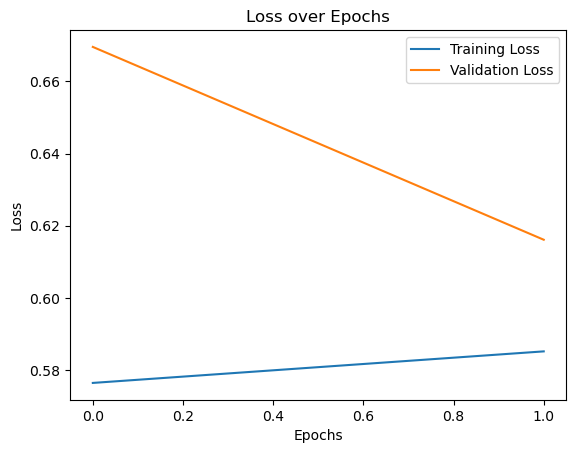

In [114]:
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Plot the loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Window Configuration

In [115]:
print(f'Window size: {window_size} data points ({window_size/200} seconds)\nWindow start: {window_size - offset} data points ({(window_size - offset)/200} seconds) before maneuver\nWindow end: {offset} data points ({offset/200} seconds) after maneuver')

Window size: 200 data points (1.0 seconds)
Window start: 300 data points (1.5 seconds) before maneuver
Window end: -100 data points (-0.5 seconds) after maneuver


Confusion Matrix

8/8 [==============================] - 0s 11ms/step


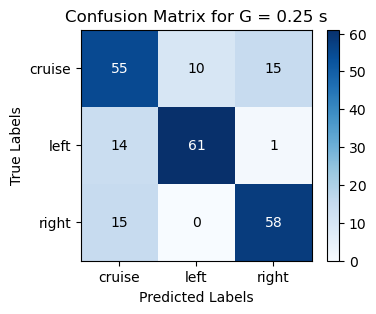

              precision    recall  f1-score   support

      cruise       0.65      0.69      0.67        80
        left       0.86      0.80      0.83        76
       right       0.78      0.79      0.79        73

    accuracy                           0.76       229
   macro avg       0.77      0.76      0.76       229
weighted avg       0.76      0.76      0.76       229

16/16 [==============================] - 0s 12ms/step
Test accuracy: | Train accuracy: | Test F1-score: | Train F1-score: 
0.760	0.760	0.761	0.763
Window size: 200 data points
 offset: -100 seconds


In [125]:
#%matplotlib qt

# Generate predictions for the testing data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

class_labels = ['cruise', 'left', 'right']

# Plot the confusion matrix
confusion = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(4, 3))
plt.imshow(confusion, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for G = ... s')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(confusion.shape[1]), labels=class_labels)
plt.yticks(ticks=np.arange(confusion.shape[0]), labels=class_labels)
# Add text annotations to the confusion matrix squares
threshold = confusion.max() / 2.0  # Adjust the threshold as needed
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        color = 'white' if confusion[i, j] > threshold else 'black'
        plt.text(j, i, str(confusion[i, j]), ha='center', va='center', color=color)
plt.colorbar()
plt.show()

# Calculate precision, recall, and f1-score
report = classification_report(y_test_classes, y_pred_classes, target_names=class_labels)
print(report)
test_f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
train_f1 = f1_score(y_train_classes, np.argmax(model.predict(X_train), axis=1), average='weighted')
test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
train_accuracy = accuracy_score(y_train_classes, np.argmax(model.predict(X_train), axis=1))
print(f'Test accuracy: | Train accuracy: | Test F1-score: | Train F1-score: \n{test_accuracy:.3f}\t{train_accuracy:.3f}\t{test_f1:.3f}\t{train_f1:.3f}')
print(f'Window size: {window_size} data points\n offset: {offset} seconds')


Speed-category test accuracies and F1:
10 km/h: 0.737, 0.733
15 km/h: 0.803, 0.804
20 km/h: 0.740, 0.746

Turn-type test accuracies and F1:
0: 0.841, 0.914
1: 0.738, 0.841

Speed-category and turn-type test accuracies and F1:
10 km/h, 0: 0.867, 0.929
10 km/h, 1: 0.800, 0.863
15 km/h, 0: 0.931, 0.964
15 km/h, 1: 0.700, 0.819
20 km/h, 0: 0.724, 0.840
20 km/h, 1: 0.714, 0.821


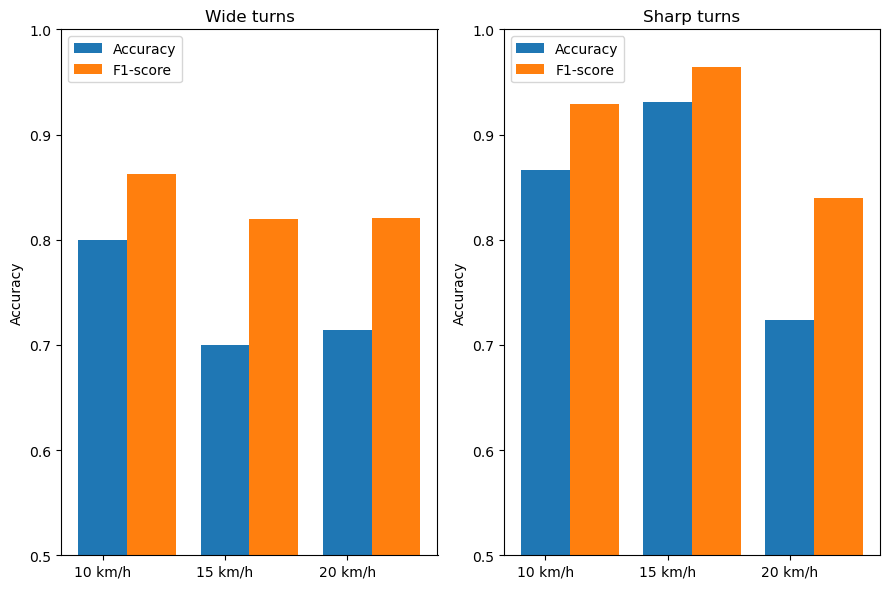

In [118]:
def get_scores(indices):
    y_pred_classes_subset = y_pred_classes[indices]
    y_test_classes_subset = y_test_classes[indices]
    accuracy = accuracy_score(y_test_classes_subset, y_pred_classes_subset)
    f1 = f1_score(y_test_classes_subset, y_pred_classes_subset, average='weighted')
    return accuracy, f1

# Get accuracy for each speed_category
speed_accuracies = {}
speed_f1 = {}
print('\nSpeed-category test accuracies and F1:')
for speed_category in [10, 15, 20]:
    indices = np.where(test_speed_categories == speed_category)
    accuracy, f1 = get_scores(indices)
    speed_accuracies[speed_category] = accuracy
    speed_f1[speed_category] = f1
    print(f'{speed_category} km/h: {accuracy:.3f}, {f1:.3f}')

# Get accuracy for each turn type
turn_accuracies = {}
turn_f1 = {}
print('\nTurn-type test accuracies and F1:')
for turn_type in [0, 1]:
    indices = np.where(test_turn_types == turn_type)
    accuracy, f1 = get_scores(indices)
    turn_accuracies[turn_type] = accuracy
    turn_f1[turn_type] = f1
    print(f'{turn_type}: {accuracy:.3f}, {f1:.3f}')

# Get testing accuracy for each combination of speed_category and turn_type
print('\nSpeed-category and turn-type test accuracies and F1:')
speed_turn_accuracies = {}
speed_turn_f1 = {}
for speed_category in [10, 15, 20]:
    for turn_type in [0, 1]:
        indices = np.where((test_speed_categories == speed_category) & (test_turn_types == turn_type))
        accuracy, f1 = get_scores(indices)
        print(f'{speed_category} km/h, {turn_type}: {accuracy:.3f}, {f1:.3f}')
        speed_turn_accuracies[(speed_category, turn_type)] = accuracy
        speed_turn_f1[(speed_category, turn_type)] = f1

# Extracting the data for each plot
speeds = [10, 15, 20, 10, 15, 20]
turns = [1, 1, 1, 0, 0, 0]
accuracies = [speed_turn_accuracies[(s, t)] for t in [1, 0] for s in [10, 15, 20]]
f1_scores = [speed_turn_f1[(s, t)] for t in [1, 0] for s in [10, 15, 20]]
# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
# Plot for wide turns
wide_turns_speeds = [speeds[i] for i, turn in enumerate(turns) if turn == 1]
wide_turns_accuracies = [accuracies[i] for i, turn in enumerate(turns) if turn == 1]
wide_turns_f1 = [f1_scores[i] for i, turn in enumerate(turns) if turn == 1]
x_positions_wide = np.arange(len(wide_turns_speeds))
ax1.bar(x_positions_wide, wide_turns_accuracies, width=0.4, tick_label=wide_turns_speeds, label='Accuracy')
ax1.bar(x_positions_wide + 0.4, wide_turns_f1, width=0.4, tick_label=wide_turns_speeds, label='F1-score')
ax1.set_xticks(x_positions_wide)
ax1.set_xticklabels([f"{speed} km/h" for speed in wide_turns_speeds])
ax1.set_ylabel("Accuracy")
ax1.set_title("Wide turns")
ax1.set_ylim(0.5, 1)
ax1.legend(loc='upper left')
# Plot for sharp turns
sharp_turns_speeds = [speeds[i] for i, turn in enumerate(turns) if turn == 0]
sharp_turns_accuracies = [accuracies[i] for i, turn in enumerate(turns) if turn == 0]
sharp_turns_f1 = [f1_scores[i] for i, turn in enumerate(turns) if turn == 0]
x_positions_sharp = np.arange(len(sharp_turns_speeds))
ax2.bar(x_positions_sharp, sharp_turns_accuracies, width=0.4, tick_label=sharp_turns_speeds, label='Accuracy')
ax2.bar(x_positions_sharp + 0.4, sharp_turns_f1, width=0.4, tick_label=sharp_turns_speeds, label='F1-score')
ax2.set_xticks(x_positions_sharp)
ax2.set_xticklabels([f"{speed} km/h" for speed in sharp_turns_speeds])
ax2.set_ylabel("Accuracy")
ax2.set_title("Sharp turns")
ax2.set_ylim(0.5, 1)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()


Visualising Feature Maps of Convolutional Layer

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8_input (InputLayer)  [(None, 200, 5)]         0         
                                                                 
 conv1d_8 (Conv1D)           (None, 200, 16)           576       
                                                                 
Total params: 576
Trainable params: 576
Non-trainable params: 0
_________________________________________________________________
None
Looking at a maneuver with label: c


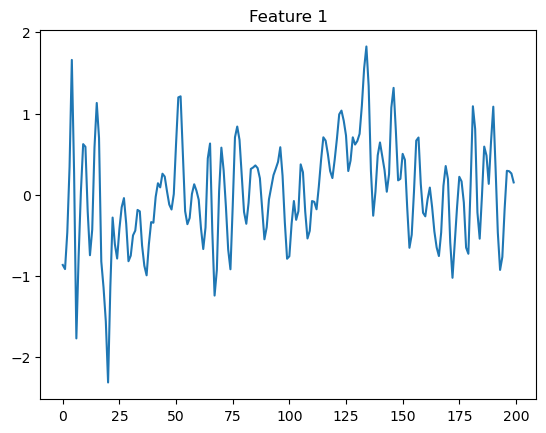

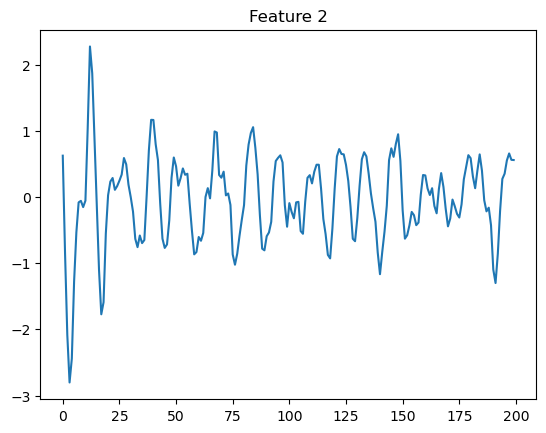

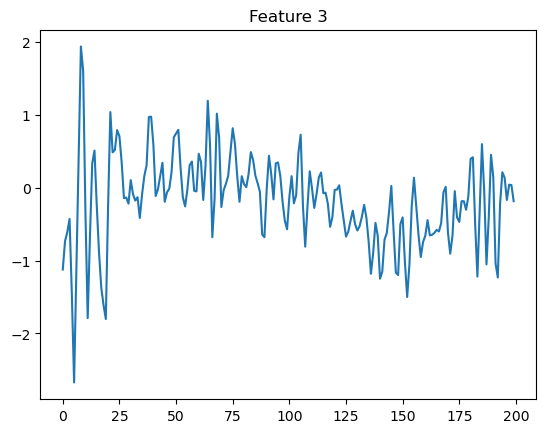

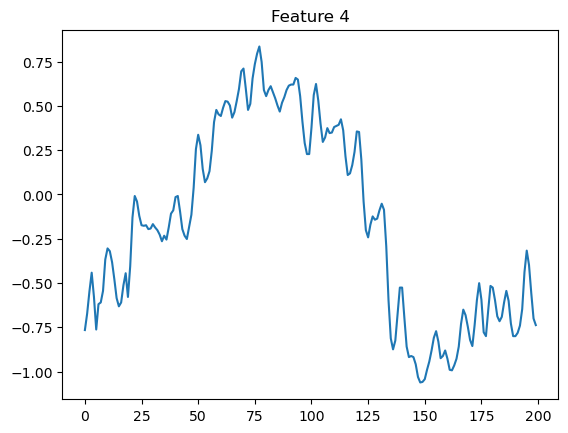

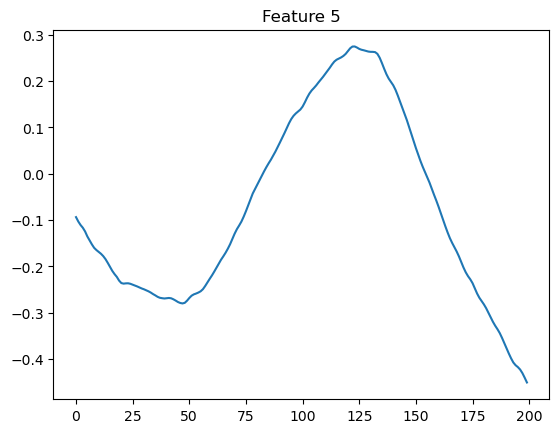

1/1 [==============================] - 0s 67ms/step


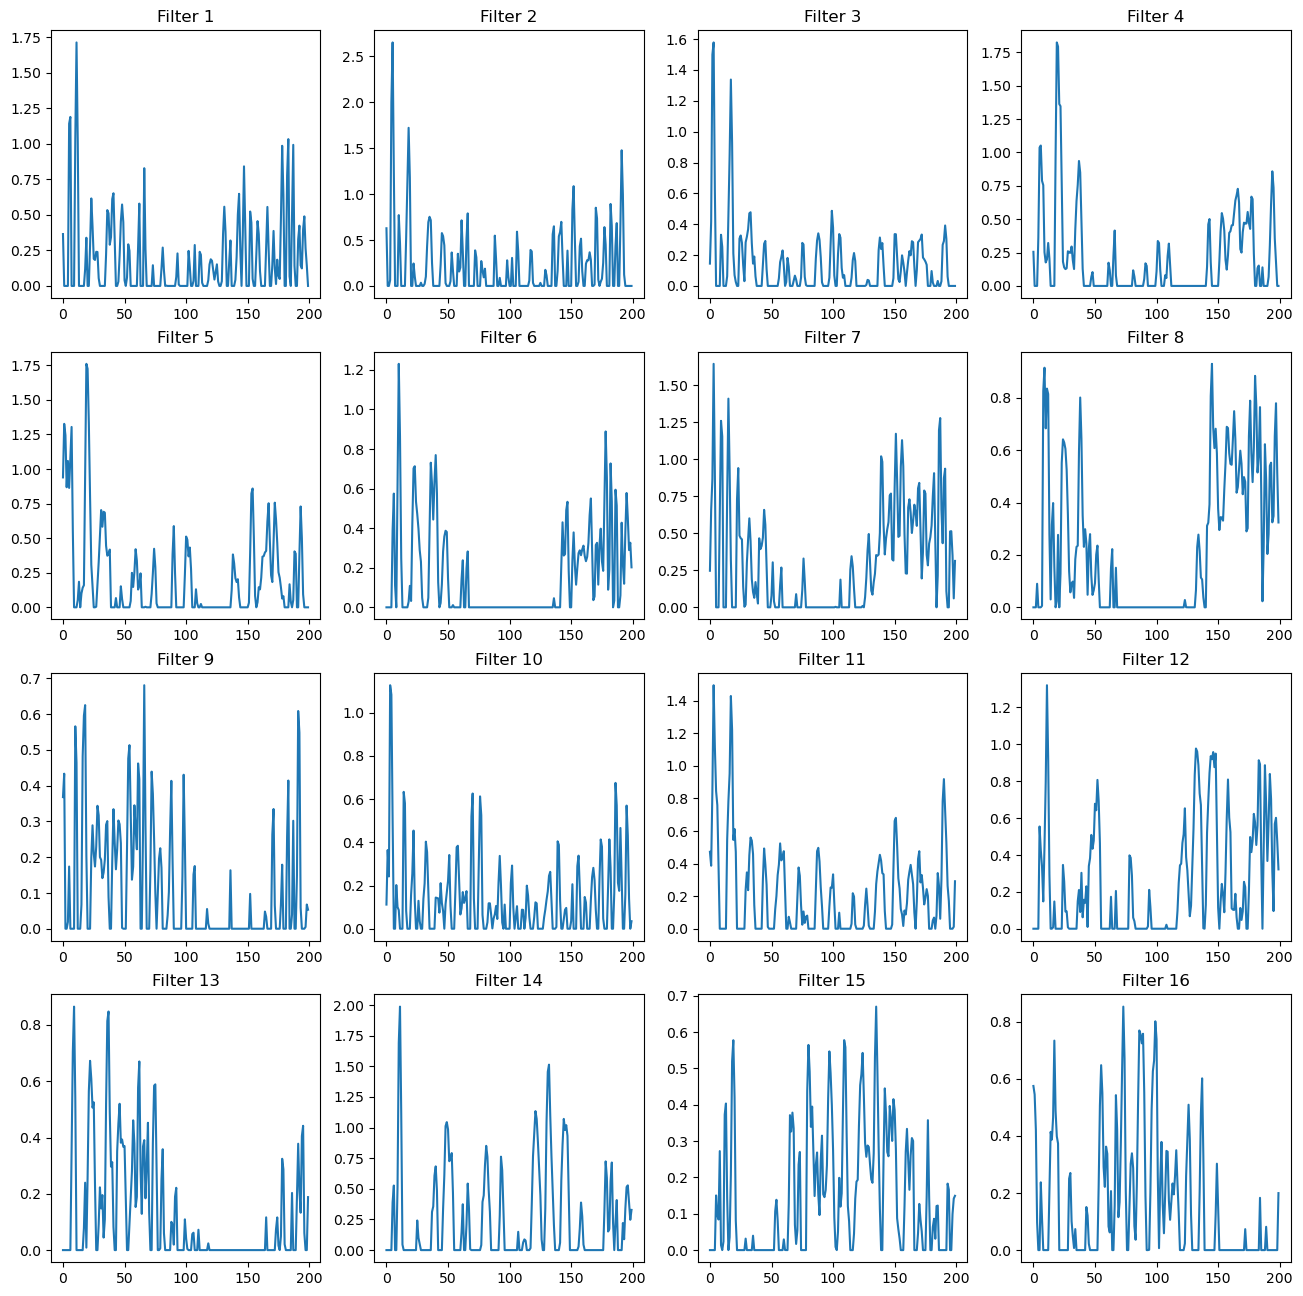

In [102]:
from keras import Model
# from https://www.youtube.com/watch?v=ho6JXE3EbZ8
model_short = Model(inputs = model.inputs, outputs = model.layers[1].output)
print(model_short.summary())

sample_nr = 5
print(f'Looking at a maneuver with label: {one_hot_dict[np.argmax(y_test[sample_nr])]}')
sample = X_test[sample_nr]  # Get single sample from X_test
#print(sample.shape)

#Plot each feature and give them each their own plot, the amount of plots should be input_dimensions
for i in range(0, input_dimensions):
    plt.plot(sample[:, i])
    plt.title(f'Feature {i+1}')
    plt.show()

sample = np.expand_dims(sample, axis=0) #Expand dimensions to match input shape

#Plot feature maps
feature_maps = model_short.predict(sample)
fig = plt.figure(figsize=(16, 16))
for i in range(1, 16+1):
    f = feature_maps[:, :, i-1]
    ax = fig.add_subplot(4, 4, i)
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.plot(f[0])
    ax.set_title(f'Filter {i}')
plt.show()

In [103]:
for i in range(0,10):
    print(f'{i}: {one_hot_dict[np.argmax(y_test[i])]}')

0: c
1: r
2: l
3: c
4: r
5: c
6: l
7: c
8: c
9: l
